In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e1_general_model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_received_signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 5
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples=10

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=500, stopping_criterion=1e-4):
    # Correlation Aware Sparse Bayesian Learning (sbl) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for SBL results
z_sbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # SBL results
gamma_sbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # SBL gamma values
hit_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for SBL
support_recovery_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for SBL
false_alarm_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for SBL
norm_mse_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for SBL

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_sbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for SBL
        hit_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for sbl
        support_recovery_rate_sbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for SBL
        false_alarm_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for SBL
        norm_mse_sbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  89%|████████▉ | 8/9 [02:12<00:16, 16.70s/it]

Converged after 443 iterations



Processing Samples: 100%|██████████| 10/10 [25:12<00:00, 151.28s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_sbl = np.mean(support_recovery_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [34. 41. 65. 78. 85. 93. 97. 98. 98.]
Average Support Recovery Rate across samples per SNR level: [0.13807761 0.18023763 0.3170281  0.45379789 0.53982496 0.6631543
 0.70010027 0.77764902 0.81753247]
Average False Alarm Rate across samples per SNR level: [2.51282051 2.58974359 2.12820513 1.51282051 1.28205128 1.05128205
 1.02564103 0.66666667 0.51282051]
Average Normalized MSE across samples per SNR level: [0.79102363 0.73290894 0.47622905 0.33531942 0.21352659 0.15745492
 0.1203338  0.0846796  0.07086415]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e1_simulation_results_sbl_pilot_length_all_snr_db_5.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    support_recovery_rate_sbl=support_recovery_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_support_recovery_rate_sbl=avg_support_recovery_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


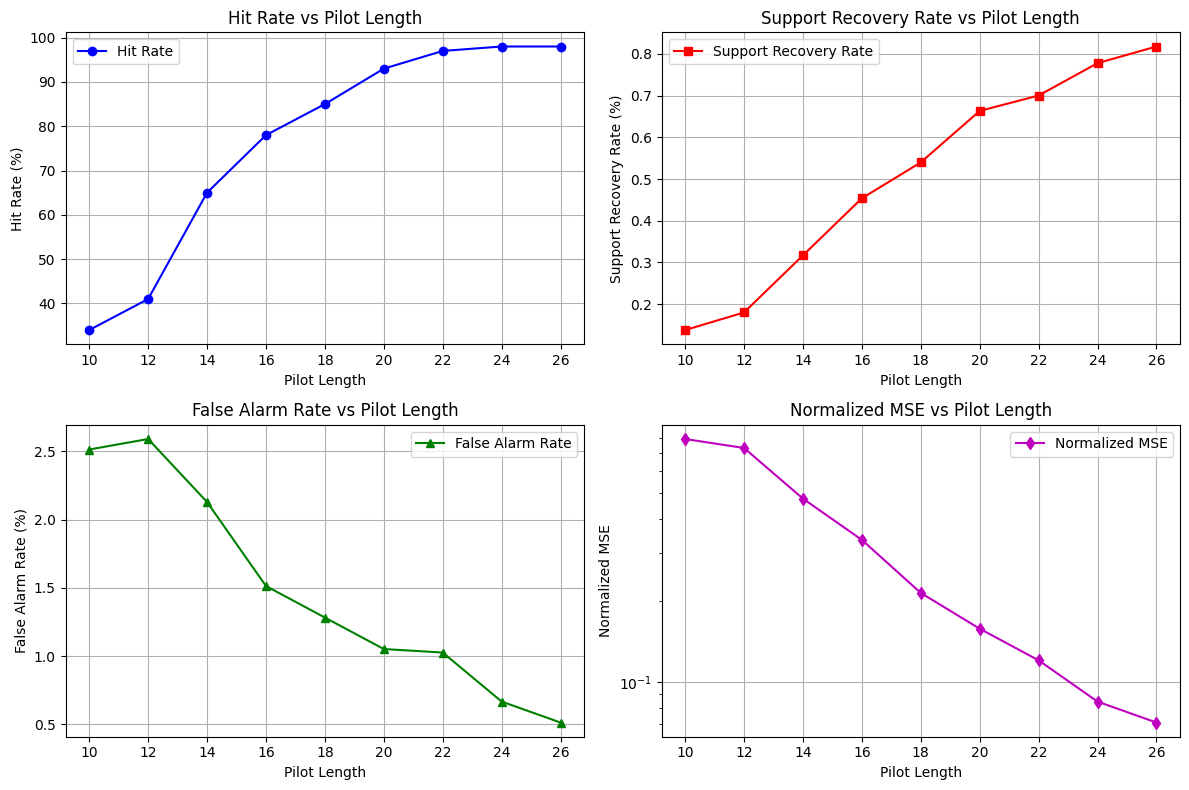

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_sbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
